# Classifying MNIST Digits using an Multi-Layer Perceptron

### First we organize out imports of libraries and functions we will need to use.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Load the MNIST Dataset using Tensorflow's built in data loader. 

In [2]:
# Download and parse the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Transform the images from the range [0..255] uint8 to [0..1] float32
x_train = np.expand_dims(x_train.astype(np.float32) / 255.0, axis=-1) # [60000, 28, 28, 1]
x_test  = np.expand_dims( x_test.astype(np.float32) / 255.0, axis=-1) # [10000, 28, 28, 1]
# Dimensions of image data is [num_images, height, width, channel]

### Debug the dataset by plotting some images and their true labels from the test set.

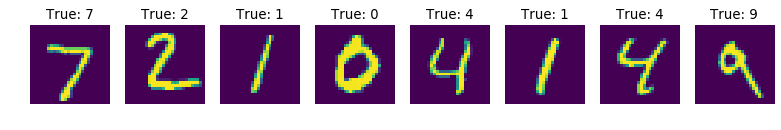

In [3]:
# Plot a series of images from the test set with their true labels
plt.figure(figsize=(12,2), dpi=80)    
num_images_to_show = 8
for idx in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, idx + 1)
    plt.axis('off')
    
    # x_train is a 4-dimensional array, we want to slice out a single 28x28 pixel image
    plt.imshow(x_test[idx,:,:,0])
    plt.title('True: %d' % (y_test[idx]))
    
plt.show()

### Define and train a 2-layer Multi-Layer Perceptron.

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.2181 - accuracy: 0.9352 - val_loss: 0.1055 - val_accuracy: 0.9695
Epoch 2/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0975 - accuracy: 0.9701 - val_loss: 0.0787 - val_accuracy: 0.9749
Epoch 3/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0682 - accuracy: 0.9791 - val_loss: 0.0674 - val_accuracy: 0.9789
Epoch 4/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.0547 - accuracy: 0.9826 - val_loss: 0.0679 - val_accuracy: 0.9785
Epoch 5/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.0644 - val_accuracy: 0.9807


### Debug the model by plotting some images, their true labels, and their predicted labels from the test set.

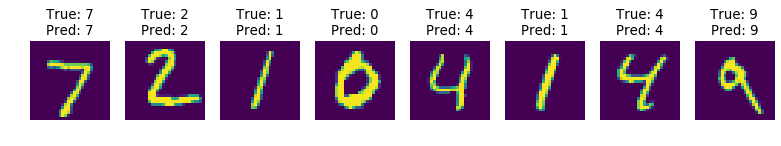

In [5]:
# Plot a series of images from the test set with their true and predicted labels
plt.figure(figsize=(12,2), dpi=80)    
num_images_to_show = 8
for idx in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, idx + 1)
    plt.axis('off')
    
    # Perform inference on a single image, need to put it in a batch with batch size 1
    batch = np.expand_dims(x_test[idx], axis=0) # batch has size [1, 28, 28, 1]
    probs = model.predict(batch)                # probs has size [1, 10]
    pred_class = np.argmax(probs[0])            # predicted class is an integer
    
    # x_train is a 4-dimensional array, we want to slice out a single 28x28 pixel image
    plt.imshow(x_test[idx,:,:,0])
    plt.title('True: %d\nPred: %d' % (y_test[idx], pred_class))
    
plt.show()